In [ ]:
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
# Asumimos que los datos están en un archivo CSV llamado 'datos.csv'
nombre_csv=1
df= pd.read_csv(f'../Data1_actividad/{nombre_csv}_act.csv')


# Convertir 'Fecha' y 'Hora' a datetime
df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()

# Resampling a frecuencia horaria (por si acaso hay datos faltantes)
df_resampled = df['activity_level'].resample('H').mean().fillna(method='ffill')

# Transformada de Fourier
n = len(df_resampled)
fft_result = fft(df_resampled.values)
freq = np.fft.fftfreq(n, d=1/24)  # Frecuencias en ciclos por día

# Calcular la magnitud del espectro
magnitude = np.abs(fft_result)

# Plotear el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(freq[:n//2], magnitude[:n//2])
plt.title('Espectro de Frecuencias')
plt.xlabel('Frecuencia (ciclos por día)')
plt.ylabel('Magnitud')
plt.xlim(0, 5)  # Limitamos a 5 ciclos por día para mejor visualización
plt.show()

# Identificar la frecuencia del ciclo circadiano (cercana a 1 ciclo por día)
circadian_freq = freq[np.argmax(magnitude[1:n//2]) + 1]
print(f"Frecuencia del ciclo circadiano: {circadian_freq:.2f} ciclos por día")

# Reconstruir la señal usando solo las frecuencias cercanas al ciclo circadiano
fft_filtered = fft_result.copy()
fft_filtered[(freq < 0.5) | (freq > 1.5)] = 0  # Filtrar frecuencias fuera de 0.8-1.2 ciclos/día
reconstructed_signal = np.real(np.fft.ifft(fft_filtered))

# Plotear la señal original y la reconstruida para el primer día
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index[:24], df_resampled.values[:24], label='Original')
plt.plot(df_resampled.index[:24], reconstructed_signal[:24], label='Reconstruida')
plt.title('Señal Original vs Reconstruida (primer día)')
plt.xlabel('Fecha')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.show()

# Plotear la señal original y la reconstruida
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled.values, label='Original')
plt.plot(df_resampled.index, reconstructed_signal, label='Reconstruida')
plt.title('Señal Original vs Reconstruida')
plt.xlabel('Fecha')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.show()

# Distancia Euclidiana
# Reorganizar los datos en una matriz donde cada fila es un día
daily_data = df_resampled.values.reshape(-1, 24)

# Calcular la matriz de distancias
dist_matrix = pdist(daily_data, metric='euclidean')
dist_matrix = squareform(dist_matrix)

# Visualizar la matriz de distancias
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='viridis')
plt.title('Matriz de Distancias Euclidianas entre Días')
plt.xlabel('Día')
plt.ylabel('Día')
plt.show()

# Identificar los días más diferentes (mayor distancia promedio a otros días)
avg_distances = np.mean(dist_matrix, axis=0)
most_different_day = np.argmax(avg_distances)
print(f"El día más diferente es el día {most_different_day + 1}")

# Plotear el día más diferente vs el día promedio
avg_day = np.mean(daily_data, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(range(24), daily_data[most_different_day], label='Día más diferente')
plt.plot(range(24), avg_day, label='Día promedio')
plt.title('Comparación del Día Más Diferente vs Día Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.show()


In [ ]:
magnitude

Frecuencia del ciclo circadiano: 1.00 ciclos por día


C:\Users\PC\AppData\Local\Temp\ipykernel_20112\3368429382.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df['activity_level'].resample('H').mean().fillna(method='ffill')
C:\Users\PC\AppData\Local\Temp\ipykernel_20112\3368429382.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df['activity_level'].resample('H').mean().fillna(method='ffill')


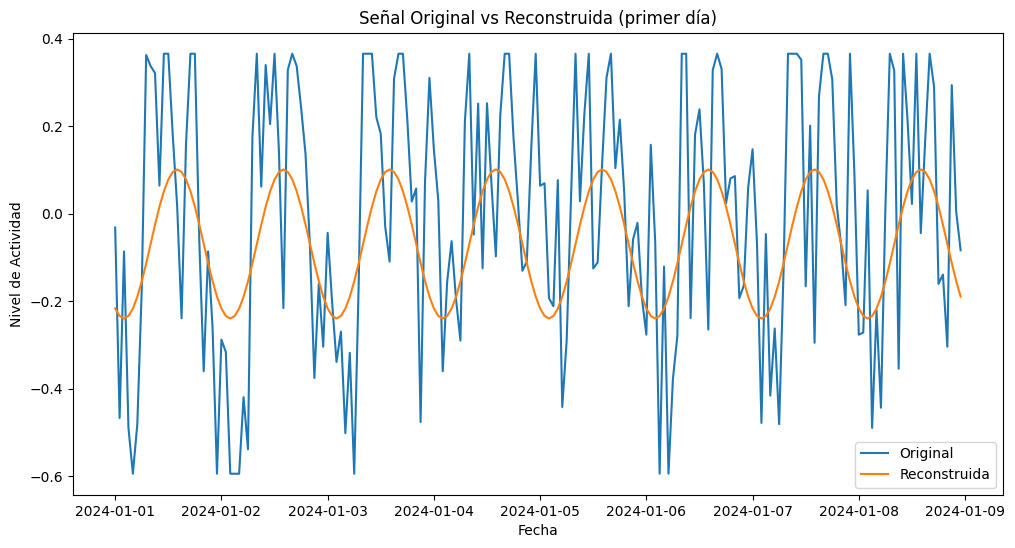

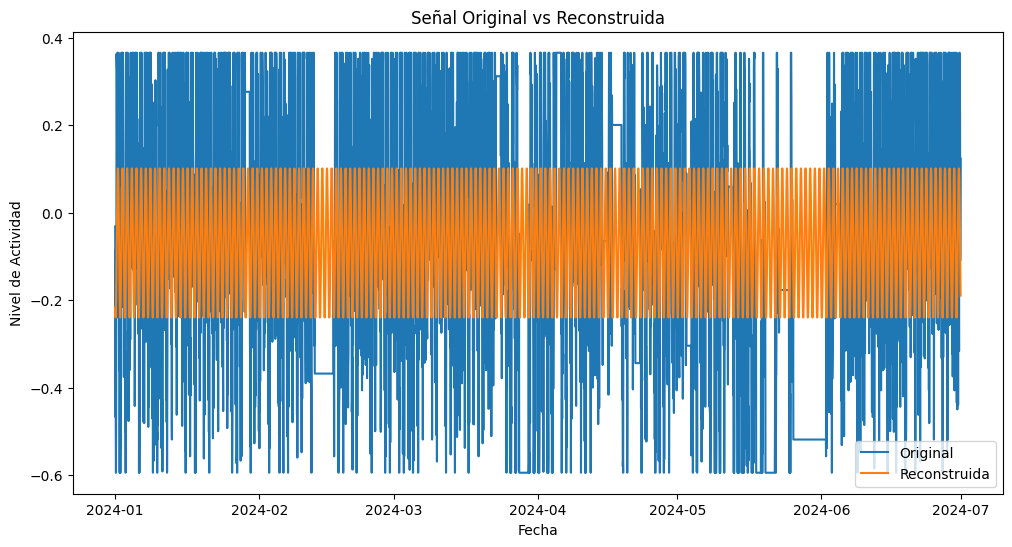

In [ ]:
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
# Asumimos que los datos están en un archivo CSV llamado 'datos.csv'
nombre_csv=4151
df= pd.read_csv(f'../Data1_actividad/{nombre_csv}_act.csv')


# Convertir 'Fecha' y 'Hora' a datetime
df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()

# Resampling a frecuencia horaria (por si acaso hay datos faltantes)
df_resampled = df['activity_level'].resample('H').mean().fillna(method='ffill')

# Transformada de Fourier
n = len(df_resampled)
fft_result = fft(df_resampled.values)
freq = np.fft.fftfreq(n, d=1/24)  # Frecuencias en ciclos por día

# Mantener solo los armónicos en el rango [-z, z]
fft_filtered = np.zeros_like(fft_result, dtype=complex)
z=1
for k in range(-z, z + 1):
    idx = np.argmin(np.abs(freq - k))  # Encuentra el índice más cercano a la frecuencia k
    fft_filtered[idx] = fft_result[idx]


# Calcular la magnitud del espectro
magnitude = np.abs(fft_result)

# Identificar la frecuencia del ciclo circadiano (cercana a 1 ciclo por día)
circadian_freq = freq[np.argmax(magnitude[1:n//2]) + 1]
print(f"Frecuencia del ciclo circadiano: {circadian_freq:.2f} ciclos por día")

# Reconstruir la señal usando solo las frecuencias cercanas al ciclo circadiano
#fft_filtered = fft_result.copy()
#fft_filtered[(freq < -1.8) | (freq > 1.8)] = 0  # Filtrar frecuencias fuera de 0.8-1.2 ciclos/día
reconstructed_signal = np.real(np.fft.ifft(fft_filtered))
ventana=192
# Plotear la señal original y la reconstruida para el primer día
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index[:ventana], df_resampled.values[:ventana], label='Original')
plt.plot(df_resampled.index[:ventana], reconstructed_signal[:ventana], label='Reconstruida')
plt.title('Señal Original vs Reconstruida (primer día)')
plt.xlabel('Fecha')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.show()

# Plotear la señal original y la reconstruida
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled.values, label='Original')
plt.plot(df_resampled.index, reconstructed_signal, label='Reconstruida')
plt.title('Señal Original vs Reconstruida')
plt.xlabel('Fecha')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.show()




In [ ]:
magnitude